<a href="https://colab.research.google.com/github/jidan-fikri/AWAN-App/blob/master/Awan_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import keras
import cv2
import tensorflow as tf
import zipfile
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!gdown 1nwrZlRkl4c5nXQPYtz_6_ZhHC1b2HVKn
with zipfile.ZipFile('cloud2.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/cloud-classifier')

Downloading...
From: https://drive.google.com/uc?id=1nwrZlRkl4c5nXQPYtz_6_ZhHC1b2HVKn
To: /content/cloud2.zip
100% 95.1M/95.1M [00:00<00:00, 283MB/s]


In [3]:
base_dir = '/content/cloud-classifier'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [25]:
BATCH_SIZE = 8
IMAGE_SIZE = 224

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE  
)

Found 2100 files belonging to 3 classes.
Found 236 files belonging to 3 classes.


In [5]:
class_names = train_dataset.class_names
class_names

['Heavy_Rain', 'Low_Chance_of_Rain', 'Medium_Rain']

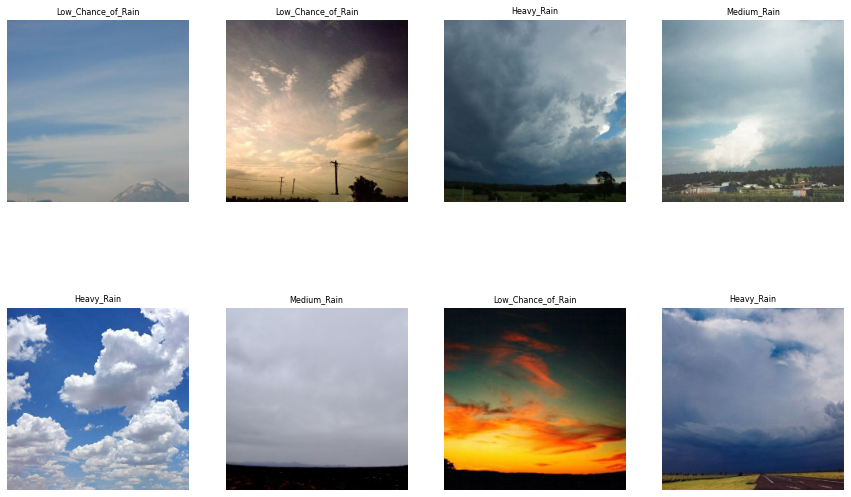

In [6]:
 plt.figure(figsize = (15,15))
 for image_batch, label_batch in train_dataset.take(1):
   for i in range(8):
     ax = plt.subplot(3,4,i+1)
     plt.imshow(image_batch[i].numpy().astype("uint8"))
     plt.title(class_names[label_batch[i]],fontsize = 8)
     plt.axis("off")
  #  print(image_batch.shape[0].shape)

In [7]:
def get_dataset_partitions_tf(ds, train_split = 0.9,val_split = 0.1,shuffle = True,shuffle_size = 10000):
  assert(train_split+val_split) == 1
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 8)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  return train_ds, val_ds

In [8]:
train_ds, val_ds = get_dataset_partitions_tf(train_dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
data_augmentation = tf.keras.Sequential([
                     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#                      layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
base_model = tf.keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape,
    classes=3,
    classifier_activation="softmax",
)

87924736/87910968 [==============================] - 1s 0us/step


In [13]:
model = models.Sequential([
  base_model,
  layers.Conv2D(64, (3, 3), activation = 'relu'),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling2D(), 
  layers.Dense(3, activation='softmax'),
])
model.build(input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 conv2d_94 (Conv2D)          (None, 3, 3, 64)          1179712   
                                                                 
 dropout (Dropout)           (None, 3, 3, 64)          0         
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 22,982,691
Trainable params: 22,948,259
Non-trainable params: 34,432
_____________________________________

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
filepath = "/content/cloud.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

EPOCHS = 30
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    validation_data = val_ds,
    batch_size = BATCH_SIZE,
    callbacks = callbacks_list,
    verbose = 1,
)

Epoch 1/30
236/236 [==============================] - ETA: 0s - loss: 0.8148 - accuracy: 0.6425
Epoch 1: val_accuracy improved from -inf to 0.73077, saving model to /content/cloud.h5
236/236 [==============================] - 44s 101ms/step - loss: 0.8148 - accuracy: 0.6425 - val_loss: 0.6012 - val_accuracy: 0.7308
Epoch 2/30
236/236 [==============================] - ETA: 0s - loss: 0.6284 - accuracy: 0.7315
Epoch 2: val_accuracy did not improve from 0.73077
236/236 [==============================] - 22s 92ms/step - loss: 0.6284 - accuracy: 0.7315 - val_loss: 0.6459 - val_accuracy: 0.7212
Epoch 3/30
236/236 [==============================] - ETA: 0s - loss: 0.5357 - accuracy: 0.7881
Epoch 3: val_accuracy improved from 0.73077 to 0.74038, saving model to /content/cloud.h5
236/236 [==============================] - 23s 97ms/step - loss: 0.5357 - accuracy: 0.7881 - val_loss: 0.6090 - val_accuracy: 0.7404
Epoch 4/30
236/236 [==============================] - ETA: 0s - loss: 0.4788 - accur

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

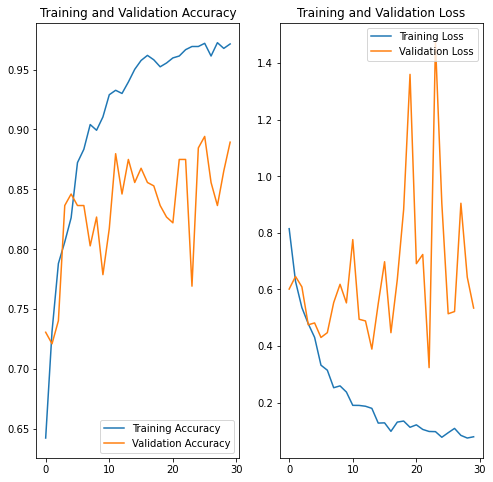

In [17]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
model = load_model("/content/cloud.h5")


In [27]:
scores = model.evaluate(test_ds)

30/30 [==============================] - 1s 30ms/step - loss: 1.3956 - accuracy: 0.7288


first image to predict
actual label: Heavy_Rain
predicted label: Heavy_Rain


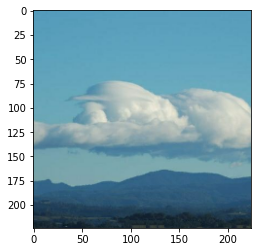

In [28]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[5].numpy().astype('uint8')
    first_label = labels_batch[5].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[5])])

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

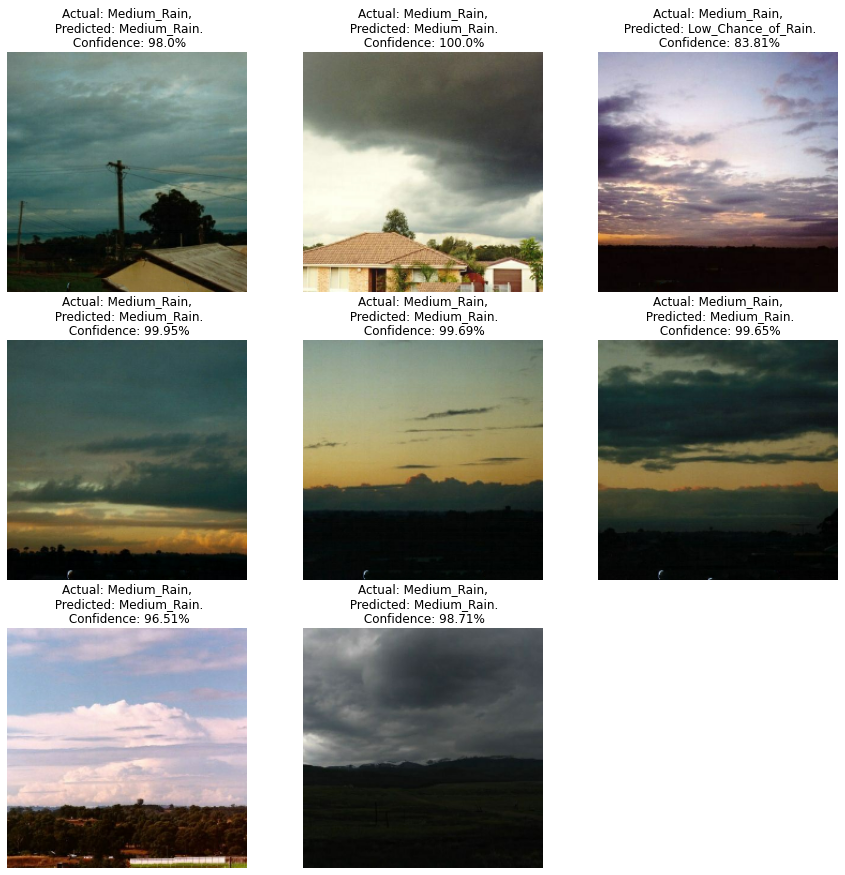

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [32]:
tflite_model = tf.keras.models.load_model("/content/cloud.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_save = converter.convert()
open("/content/cloud.tflite", "wb").write(tflite_save)

INFO:tensorflow:Assets written to: /tmp/tmpjx2yyadd/assets


23415648